# Binary Classification Model for Credit Card Default Using Python Take 4
### David Lowe
### December 3, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Credit Card Default dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

ANALYSIS: The baseline performance of the machine learning algorithms achieved an average accuracy of 79.62%. Two algorithms (Extra Trees and eXtreme Gradient Boosting) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, eXtreme Gradient Boosting turned in the top overall result and achieved an accuracy metric of 82.30%. By using the optimized parameters, the eXtreme Gradient Boosting algorithm processed the test dataset with an accuracy of 81.80%, which was consistent with the result from model training.

CONCLUSION: For this iteration, the eXtreme Gradient Boosting algorithm achieved the best overall results using the training and test datasets. For this dataset, eXtreme Gradient Boosting should be considered for further modeling.

Dataset Used: Default of Credit Card Clients Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Environment

### 1.a) Load libraries and modules

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import re
from datetime import datetime
from email.message import EmailMessage
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

Using TensorFlow backend.


### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set the number of folds for cross validation
n_folds = 10

# Set various default modeling parameters
scoring = 'accuracy'
# scoring = 'roc_auc'

In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
dataset_path = 'https://raw.githubusercontent.com/daines-analytics/datasets-public/master/default-of-credit-card-clients/default-of-credit-card-clients.csv'
Xy_original = pd.read_csv(dataset_path, sep=',', header=0, index_col=0, verbose=True)

# Take a peek at the dataframe after import
Xy_original.head(10)

Tokenization took: 83.92 ms
Type conversion took: 65.56 ms
Parser memory cleanup took: 0.01 ms


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
9,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0


In [8]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
DEFAULT      30000 non-null int64
dtypes: int64(24)
memory usage: 5.7 MB


In [9]:
Xy_original.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [10]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [11]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'DEFAULT': 'targetVar'})

# Convert columns from one data type to another
Xy_original['LIMIT_BAL'] = Xy_original['LIMIT_BAL'].astype('float')
Xy_original['SEX'] = Xy_original['SEX'].astype('category')
Xy_original['EDUCATION'] = Xy_original['EDUCATION'].astype('category')
Xy_original['MARRIAGE'] = Xy_original['MARRIAGE'].astype('category')
Xy_original['AGE'] = Xy_original['AGE'].astype('float')
Xy_original['BILL_AMT1'] = Xy_original['BILL_AMT1'].astype('float')
Xy_original['BILL_AMT2'] = Xy_original['BILL_AMT2'].astype('float')
Xy_original['BILL_AMT3'] = Xy_original['BILL_AMT3'].astype('float')
Xy_original['BILL_AMT4'] = Xy_original['BILL_AMT4'].astype('float')
Xy_original['BILL_AMT5'] = Xy_original['BILL_AMT5'].astype('float')
Xy_original['BILL_AMT6'] = Xy_original['BILL_AMT6'].astype('float')
Xy_original['PAY_AMT1'] = Xy_original['PAY_AMT1'].astype('float')
Xy_original['PAY_AMT2'] = Xy_original['PAY_AMT2'].astype('float')
Xy_original['PAY_AMT3'] = Xy_original['PAY_AMT3'].astype('float')
Xy_original['PAY_AMT4'] = Xy_original['PAY_AMT4'].astype('float')
Xy_original['PAY_AMT5'] = Xy_original['PAY_AMT5'].astype('float')
Xy_original['PAY_AMT6'] = Xy_original['PAY_AMT6'].astype('float')

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,targetVar
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24.0,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26.0,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34.0,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37.0,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57.0,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
6,50000.0,1,1,2,37.0,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
7,500000.0,1,1,2,29.0,0,0,0,0,0,...,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
8,100000.0,2,2,2,23.0,0,-1,-1,0,0,...,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0
9,140000.0,2,3,1,28.0,0,0,2,0,0,...,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0


In [12]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
LIMIT_BAL    30000 non-null float64
SEX          30000 non-null category
EDUCATION    30000 non-null category
MARRIAGE     30000 non-null category
AGE          30000 non-null float64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null float64
BILL_AMT2    30000 non-null float64
BILL_AMT3    30000 non-null float64
BILL_AMT4    30000 non-null float64
BILL_AMT5    30000 non-null float64
BILL_AMT6    30000 non-null float64
PAY_AMT1     30000 non-null float64
PAY_AMT2     30000 non-null float64
PAY_AMT3     30000 non-null float64
PAY_AMT4     30000 non-null float64
PAY_AMT5     30000 non-null float64
PAY_AMT6     30000 non-null float64
targetVar    30000 non-null int64
dtypes: category(3), float64(14), int6

In [13]:
Xy_original.describe()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,targetVar
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [14]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [15]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [16]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (30000, 24) X_original.shape: (30000, 23) y_original.shape: (30000,)


### 1.f) Set up the parameters for data visualization

In [17]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [18]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [19]:
if (notifyStatus): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [20]:
X_original.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24.0,2,2,-1,-1,-2,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
2,120000.0,2,2,2,26.0,-1,2,0,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
3,90000.0,2,2,2,34.0,0,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
4,50000.0,2,2,1,37.0,0,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
5,50000.0,1,2,1,57.0,-1,0,-1,0,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0
6,50000.0,1,1,2,37.0,0,0,0,0,0,...,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0
7,500000.0,1,1,2,29.0,0,0,0,0,0,...,445007.0,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0
8,100000.0,2,2,2,23.0,0,-1,-1,0,0,...,601.0,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0
9,140000.0,2,3,1,28.0,0,0,2,0,0,...,12108.0,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0


#### 2.a.ii) Dimensions and attribute types

In [21]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 23 columns):
LIMIT_BAL    30000 non-null float64
SEX          30000 non-null category
EDUCATION    30000 non-null category
MARRIAGE     30000 non-null category
AGE          30000 non-null float64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null float64
BILL_AMT2    30000 non-null float64
BILL_AMT3    30000 non-null float64
BILL_AMT4    30000 non-null float64
BILL_AMT5    30000 non-null float64
BILL_AMT6    30000 non-null float64
PAY_AMT1     30000 non-null float64
PAY_AMT2     30000 non-null float64
PAY_AMT3     30000 non-null float64
PAY_AMT4     30000 non-null float64
PAY_AMT5     30000 non-null float64
PAY_AMT6     30000 non-null float64
dtypes: category(3), float64(14), int64(6)
memory usage: 4.9 MB


#### 2.a.iii) Statistical summary of the attributes

In [22]:
X_original.describe()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


#### 2.a.iv) Summarize the levels of the class attribute

In [23]:
Xy_original.groupby('targetVar').size()

targetVar
0    23364
1     6636
dtype: int64

### 2.b) Data Visualization

##### 2.b.i) Univariate plots to better understand each attribute

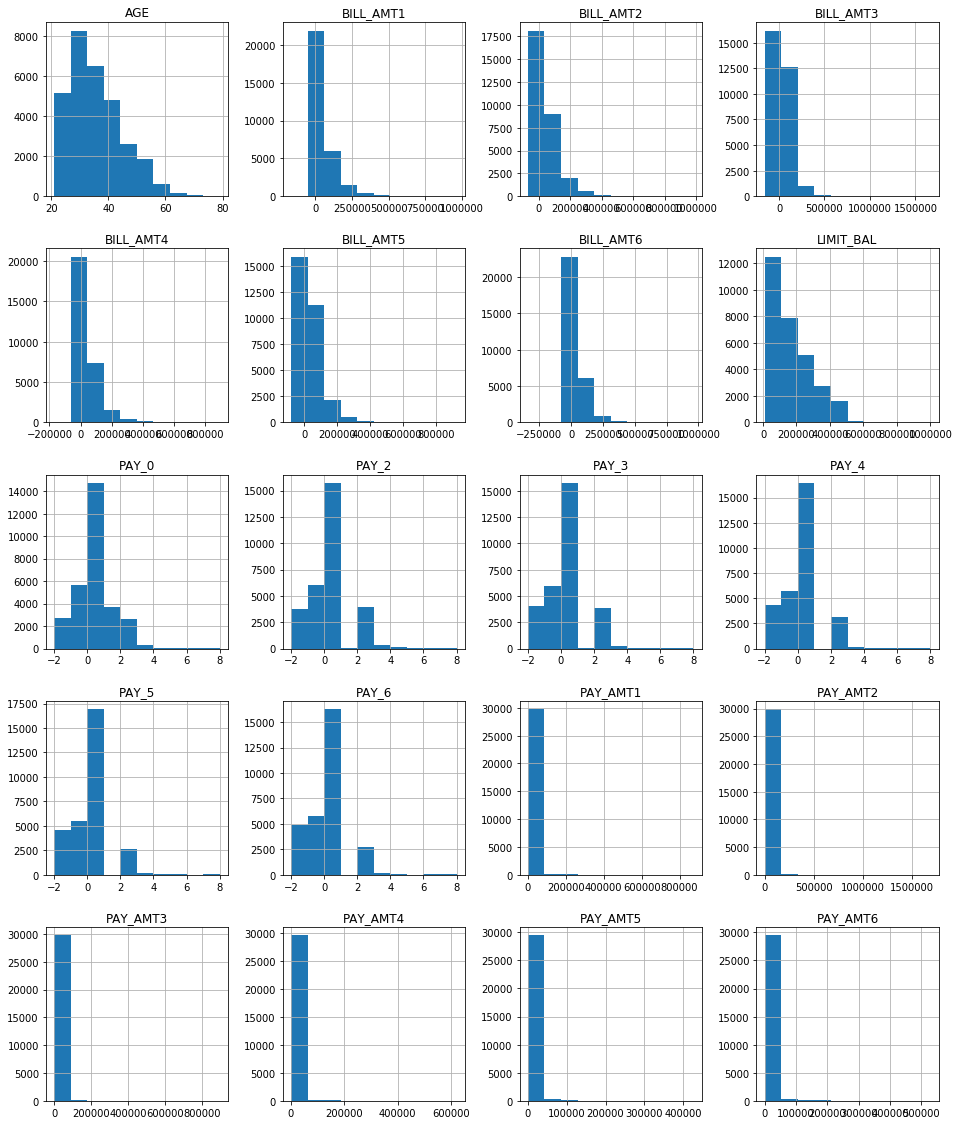

In [24]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

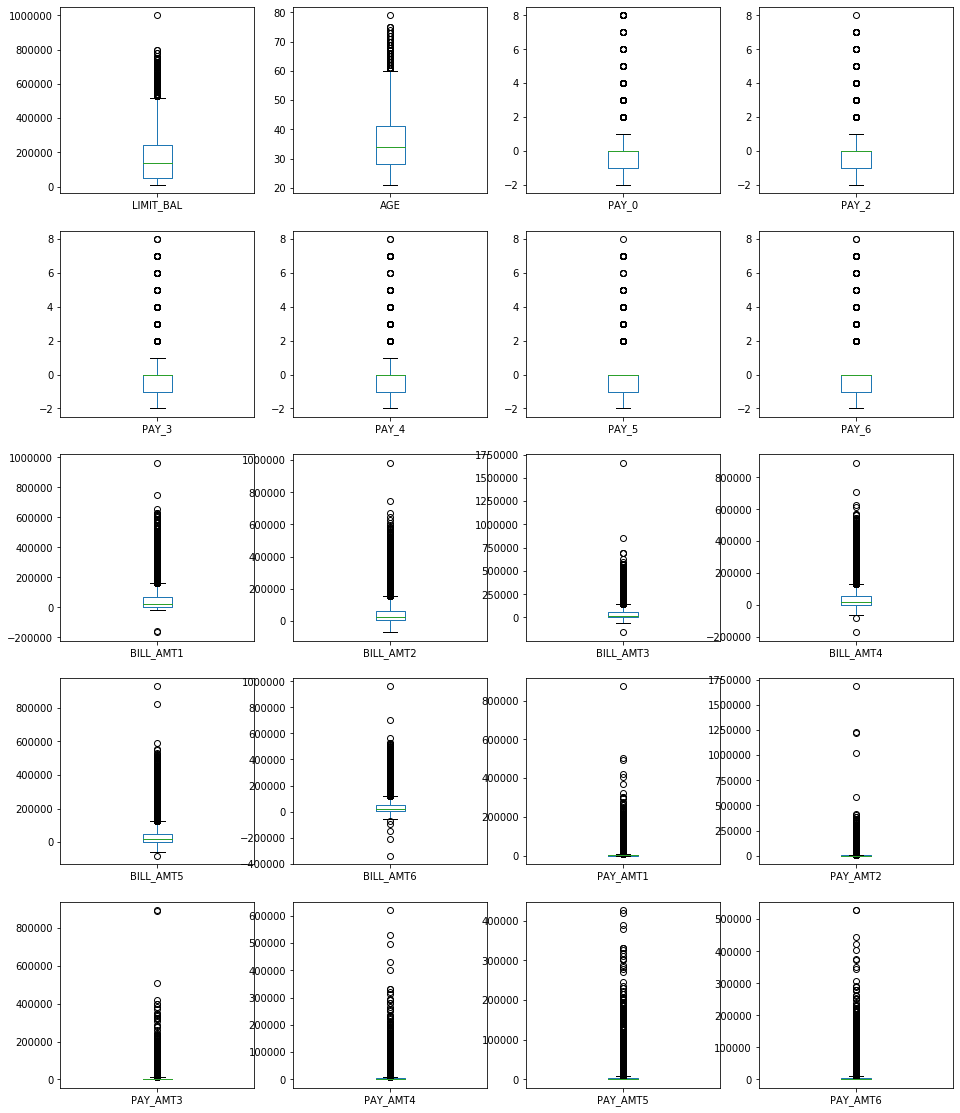

In [25]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

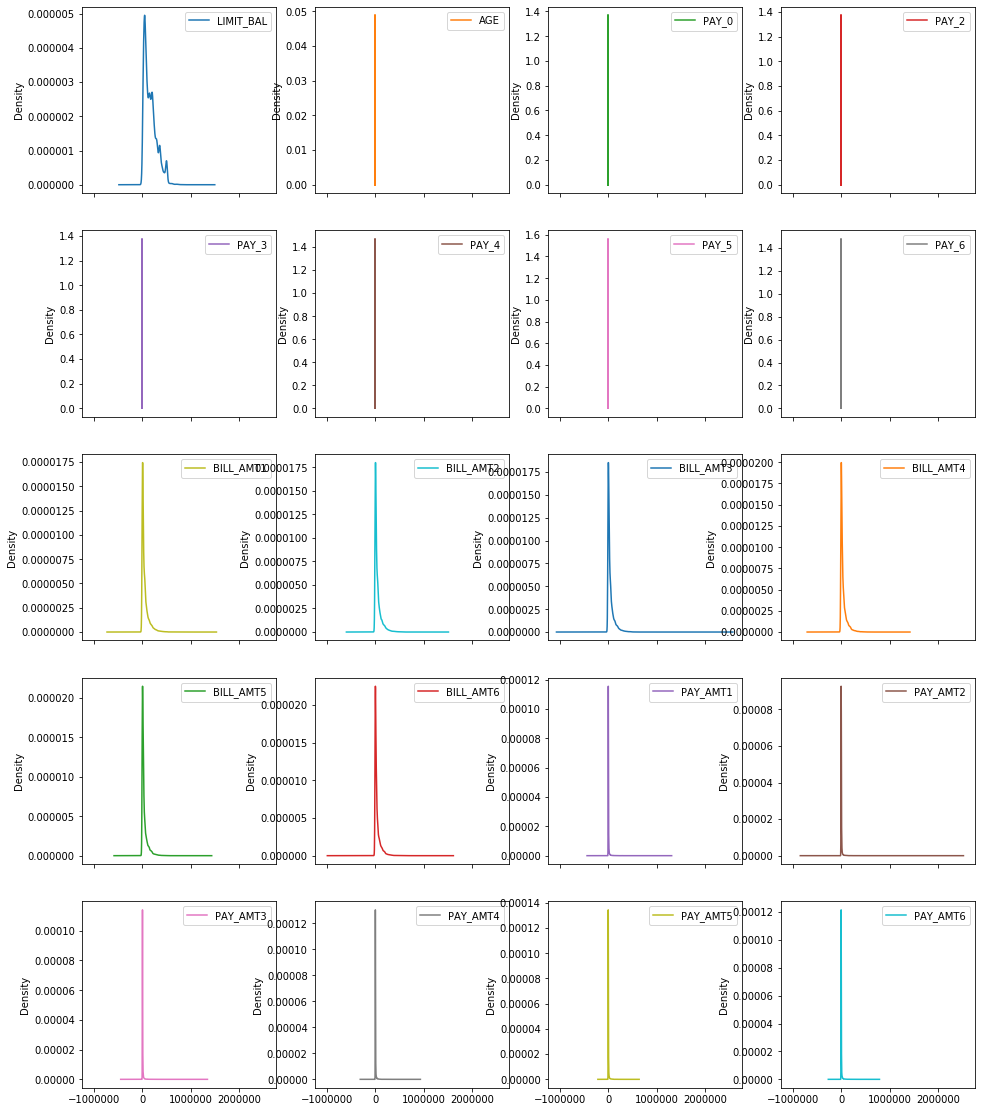

In [26]:
# Density plot for each attribute
X_original.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
plt.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [27]:
# Scatterplot matrix
# scatter_matrix(X_original)
# plt.show()

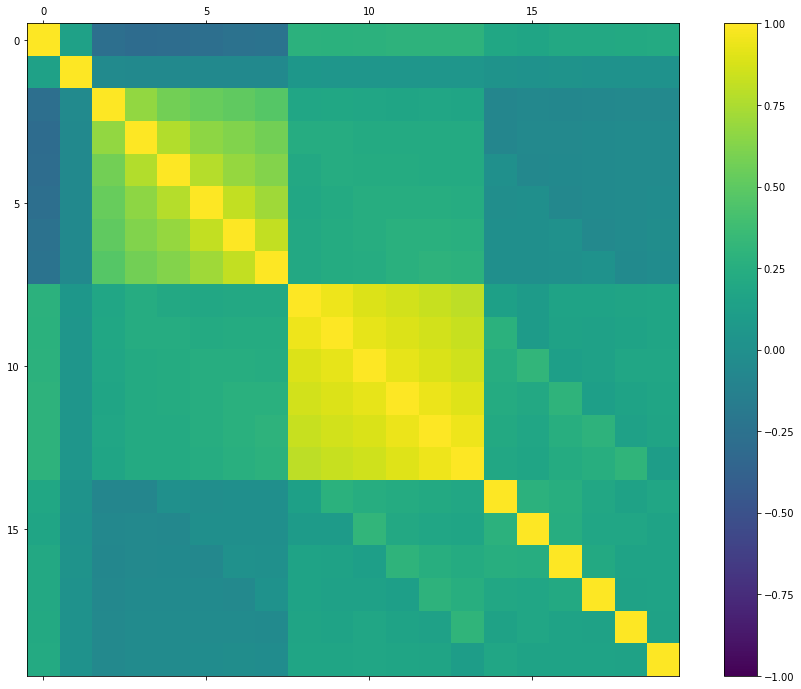

In [28]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [29]:
if (notifyStatus): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [30]:
if (notifyStatus): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [31]:
# Apply feature scaling techniques

# X_original = X_original.astype(float)
# preprocessing.scale(X_original, copy=False)
X_original['LIMIT_BAL'] = preprocessing.scale(X_original['LIMIT_BAL'])
X_original['AGE'] = preprocessing.scale(X_original['AGE'])
X_original['BILL_AMT1'] = preprocessing.scale(X_original['BILL_AMT1'])
X_original['BILL_AMT2'] = preprocessing.scale(X_original['BILL_AMT2'])
X_original['BILL_AMT3'] = preprocessing.scale(X_original['BILL_AMT3'])
X_original['BILL_AMT4'] = preprocessing.scale(X_original['BILL_AMT4'])
X_original['BILL_AMT5'] = preprocessing.scale(X_original['BILL_AMT5'])
X_original['BILL_AMT6'] = preprocessing.scale(X_original['BILL_AMT6'])
X_original['PAY_AMT1'] = preprocessing.scale(X_original['PAY_AMT1'])
X_original['PAY_AMT2'] = preprocessing.scale(X_original['PAY_AMT2'])
X_original['PAY_AMT3'] = preprocessing.scale(X_original['PAY_AMT3'])
X_original['PAY_AMT4'] = preprocessing.scale(X_original['PAY_AMT4'])
X_original['PAY_AMT5'] = preprocessing.scale(X_original['PAY_AMT5'])
X_original['PAY_AMT6'] = preprocessing.scale(X_original['PAY_AMT6'])

print(X_original.head(-10))

       LIMIT_BAL SEX EDUCATION MARRIAGE       AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                              
1      -1.136720   2         2        1 -1.246020      2      2     -1     -1   
2      -0.365981   2         2        2 -1.029047     -1      2      0      0   
3      -0.597202   2         2        2 -0.161156      0      0      0      0   
4      -0.905498   2         2        1  0.164303      0      0      0      0   
5      -0.905498   1         2        1  2.334029     -1      0     -1      0   
...          ...  ..       ...      ...       ...    ...    ...    ...    ...   
29986   0.558907   1         1        2 -0.595102     -2     -2     -2     -2   
29987   1.483795   1         1        2 -0.052670     -1     -1     -2     -2   
29988  -0.288907   1         1        2 -0.161156      0      0      0      0   
29989   0.635981   1         1        1 -0.161156      0      0      0      0   
29990  -0.134759   1        

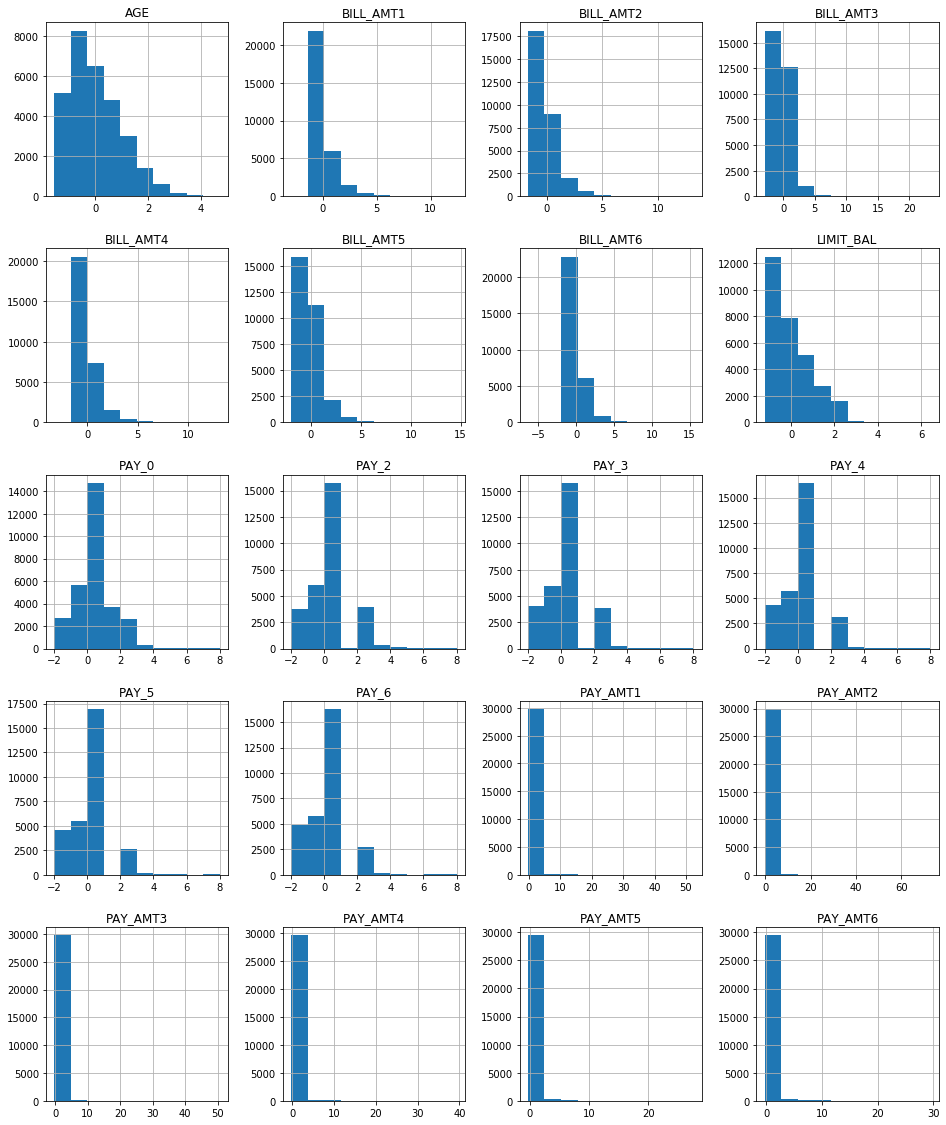

In [32]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [33]:
# Perform one-hot-encoding before splitting into trainig and test

X_original = pd.get_dummies(X_original)
print(X_original.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 33 columns):
LIMIT_BAL      30000 non-null float64
AGE            30000 non-null float64
PAY_0          30000 non-null int64
PAY_2          30000 non-null int64
PAY_3          30000 non-null int64
PAY_4          30000 non-null int64
PAY_5          30000 non-null int64
PAY_6          30000 non-null int64
BILL_AMT1      30000 non-null float64
BILL_AMT2      30000 non-null float64
BILL_AMT3      30000 non-null float64
BILL_AMT4      30000 non-null float64
BILL_AMT5      30000 non-null float64
BILL_AMT6      30000 non-null float64
PAY_AMT1       30000 non-null float64
PAY_AMT2       30000 non-null float64
PAY_AMT3       30000 non-null float64
PAY_AMT4       30000 non-null float64
PAY_AMT5       30000 non-null float64
PAY_AMT6       30000 non-null float64
SEX_1          30000 non-null uint8
SEX_2          30000 non-null uint8
EDUCATION_0    30000 non-null uint8
EDUCATION_1    30000 non-null uint8

### 3.b) Splitting Data into Training and Test Sets

In [34]:
# Split the data further into training and test datasets
if (splitDataset):
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, 
                                                                    stratify=y_original, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (22500, 33) y_train_df.shape: (22500,)
X_test_df.shape: (7500, 33) y_test_df.shape: (7500,)


### 3.c) Feature Selection

In [35]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [36]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (22500, 33) y_train.shape: (22500,)
X_test.shape: (7500, 33) y_test.shape: (7500,)


In [37]:
if (notifyStatus): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and four ensemble algorithms:

Linear Algorithm: Logistic Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged CART, Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [38]:
# Set up Algorithms Spot-Checking Array
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LGR', LogisticRegression(random_state=seedNum)))
train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('ETR', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
train_models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs)))

In [39]:
# Generate model in turn
for name, model in train_models:
	if (notifyStatus): email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if (notifyStatus): email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

LGR: 0.811022 (0.007077)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=888, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Model training time: 0:00:05.176911 

CART: 0.727422 (0.010272)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=888, splitter='best')
Model training time: 0:00:09.815863 

KNN: 0.795289 (0.009384)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs

### 4.b) Spot-checking baseline algorithms

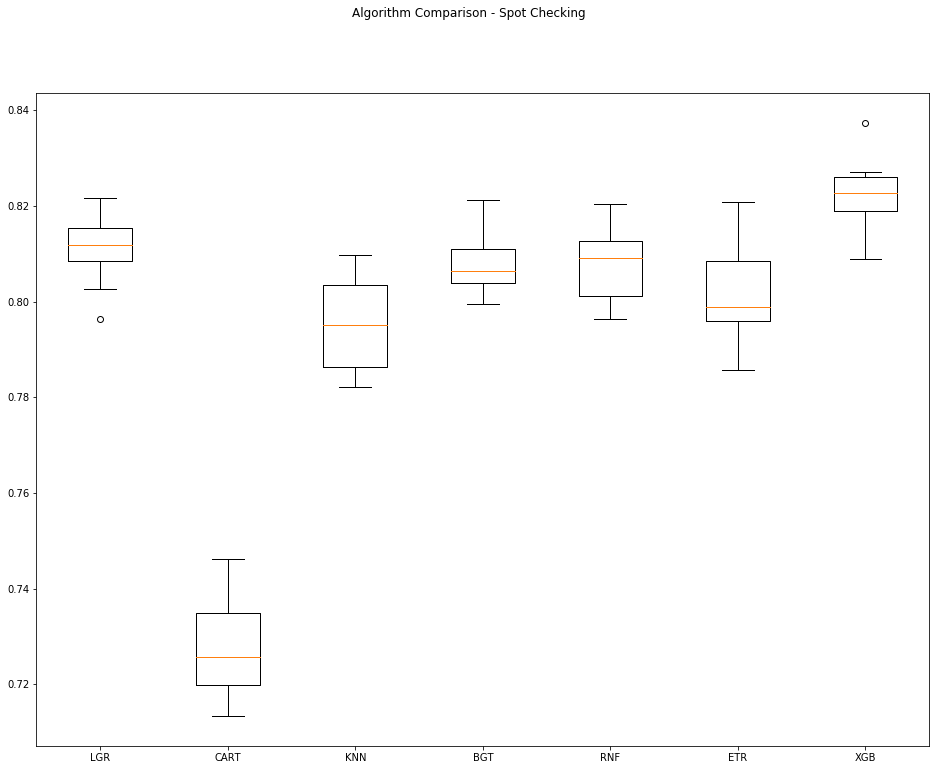

In [40]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [41]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [42]:
# Tuning algorithm #1 - Random Forest
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('RNF')
paramGrid1 = dict(n_estimators=np.array([500, 600, 700, 800, 900]))

kfold = KFold(n_splits=n_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.820444 using {'n_estimators': 800}
0.819822 (0.008003) with: {'n_estimators': 500}
0.819911 (0.007744) with: {'n_estimators': 600}
0.820133 (0.007649) with: {'n_estimators': 700}
0.820444 (0.007731) with: {'n_estimators': 800}
0.820222 (0.007475) with: {'n_estimators': 900}
Model training time: 0:13:28.301608


In [43]:
for key, value in grid_result1.best_params_.items():
    best_paramKey1 = key
    best_paramValue1 = value
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 800


In [44]:
# Tuning algorithm #2 - eXtreme Gradient Boosting
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('XGB')
paramGrid2 = dict(n_estimators=np.array([10, 25, 50, 75, 100]))

kfold = KFold(n_splits=n_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.823067 using {'n_estimators': 50}
0.821867 (0.007245) with: {'n_estimators': 10}
0.822578 (0.007204) with: {'n_estimators': 25}
0.823067 (0.007110) with: {'n_estimators': 50}
0.822889 (0.007028) with: {'n_estimators': 75}
0.822667 (0.007053) with: {'n_estimators': 100}
Model training time: 0:00:37.944497


In [45]:
for key, value in grid_result2.best_params_.items():
    best_paramKey2 = key
    best_paramValue2 = value
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 50


### 5.b) Compare Algorithms After Tuning

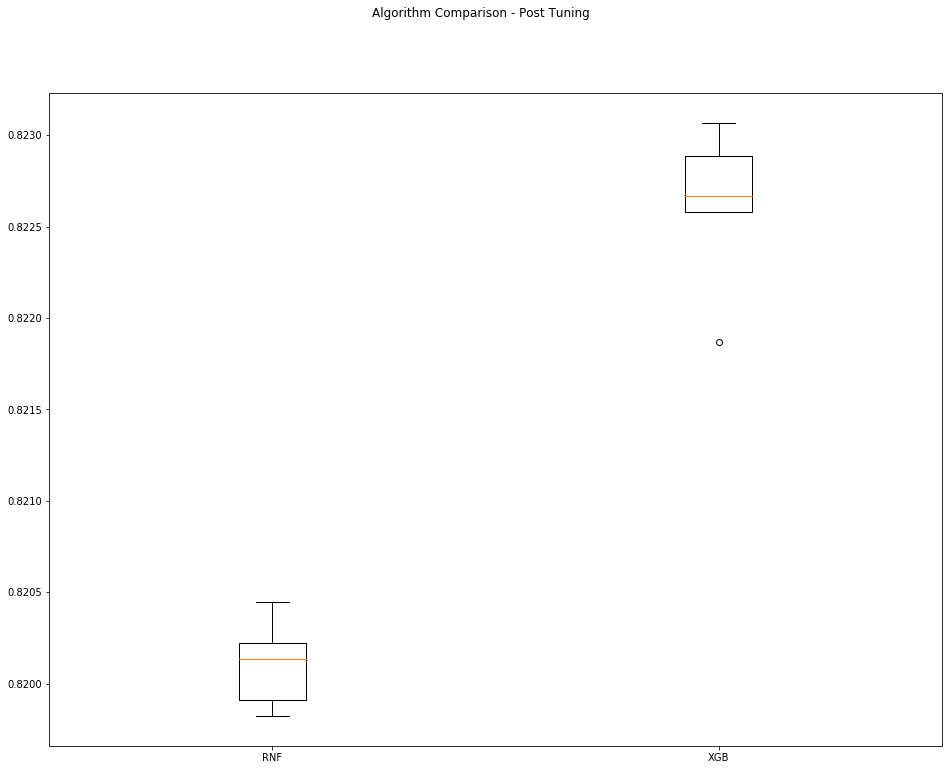

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [47]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [48]:
test_model1 = RandomForestClassifier(n_estimators=best_paramValue1, random_state=seedNum, n_jobs=n_jobs)
test_model1.fit(X_train, y_train)
predictions1 = test_model1.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions1))
print('ROC/AUC Score:', roc_auc_score(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))
print(test_model1)

Accuracy Score: 0.8124
ROC/AUC Score: 0.6553580987178926
[[5473  368]
 [1039  620]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      5841
           1       0.63      0.37      0.47      1659

    accuracy                           0.81      7500
   macro avg       0.73      0.66      0.68      7500
weighted avg       0.79      0.81      0.79      7500

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False)


In [49]:
test_model2 = XGBClassifier(n_estimators=best_paramValue2, random_state=seedNum, n_jobs=n_jobs)
test_model2.fit(X_train, y_train)
predictions2 = test_model2.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions2))
print('ROC/AUC Score:', roc_auc_score(y_test, predictions2))
print(confusion_matrix(y_test, predictions2))
print(classification_report(y_test, predictions2))
print(test_model2)

Accuracy Score: 0.818
ROC/AUC Score: 0.6511851280141346
[[5551  290]
 [1075  584]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5841
           1       0.67      0.35      0.46      1659

    accuracy                           0.82      7500
   macro avg       0.75      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


### 6.b) Create a standalone model using all available data

In [50]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_test))
y_complete = np.concatenate((y_train, y_test))
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
finalModel = test_model2

X_complete.shape: (30000, 33) y_complete.shape: (30000,)


### 6.c) Save the final model for later use

In [51]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [52]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [53]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:19:31.183972
